In [1]:
import torch
import torch.nn as nn

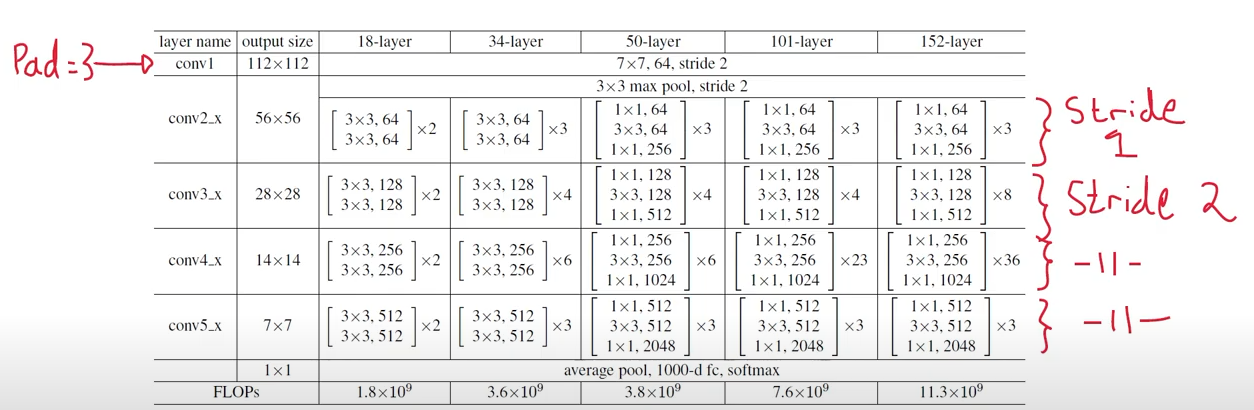

In [2]:
class block(nn.Module):
    # identity --> Sequential : in_channels --> final channel mapping 
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [3]:
class ResNet(nn.Module):  # layers : block 반복수 
    def __init__(self, block, layers, image_channels = 3, num_classes = 1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(block, layers[0], first_channels = 64, stride = 1 ) # --> 256C
        self.layer2 = self._make_layer(block, layers[1], first_channels = 128, stride = 2 ) # --> 512
        self.layer3 = self._make_layer(block, layers[2], first_channels = 256, stride = 2 )
        self.layer4 = self._make_layer(block, layers[3], first_channels = 512, stride = 2 )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_residual_blocks, first_channels, stride):
        identity_downsample = None
        layers = []
        
        # input --> 1x1로 conv로 채널 수 맞추어 줌
        if stride != 1 or self.in_channels != first_channels * 4:
            identity_downsample = nn.Sequential(
                        nn.Conv2d(self.in_channels, first_channels * 4, kernel_size=1, stride=stride),
                        nn.BatchNorm2d(out_channels * 4)
                        ) # (x)
            
        layers.append(
            block(self.in_channels, first_channels, identity_downsample, stride))
        
        self.in_channels = first_channels * 4
        # layer1 : 64 --> 256
        # layer2 : 256 --> 128 * 4 = 512
        # layer3 : 512 --> 256
        # layer4 : 256 --> 512 * 4 = 1024
        

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, first_channels))
            
        return nn.Sequential(*layers)

In [7]:
def ResNet50(img_channels = 3, num_classes = 1000):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels = 3, num_classes = 1000):
    return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels = 3, num_classes = 1000):
    return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

In [8]:
def test():
    net = ResNet50()
    x = torch.randn(2, 3, 224, 224)
    y = net(x)
    print(y.shape)

In [9]:
test()

torch.Size([2, 1000])
